In [71]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time

In [72]:
#from google.colab import drive
#drive.mount('/content/drive')

start fr here!

In [73]:
text = open('/content/drive/MyDrive/Colab Notebooks/text_electronic.txt', 'rb').read().decode(encoding='utf-8')

In [74]:
# The unique characters in the file
vocab = sorted(set(text))
print('{} unique characters'.format(len(vocab)))
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

53 unique characters


In [75]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [76]:
# The maximum length sentence you want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [77]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [78]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [79]:
# Batch size
BATCH_SIZE = 10

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset element_spec=(TensorSpec(shape=(10, 100), dtype=tf.int64, name=None), TensorSpec(shape=(10, 100), dtype=tf.int64, name=None))>

In [80]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [81]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                                  batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(rnn_units,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

In [82]:
vocab_size

53

In [83]:
model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [84]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(10, 100, 53) # (batch_size, sequence_length, vocab_size)


In [85]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (10, None, 256)           13568     
                                                                 
 gru_4 (GRU)                 (10, None, 1024)          3938304   
                                                                 
 dense_4 (Dense)             (10, None, 53)            54325     
                                                                 
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


In [86]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [87]:
sampled_indices

array([33,  9, 11, 18, 15, 38, 21, 45, 21,  3, 42, 13, 21, 36, 32, 51, 40,
       25, 28, 41, 15,  6, 20, 49,  3, 31,  2,  9, 16, 38,  6, 44, 20, 42,
       40, 20, 50, 33,  7, 25,  5,  7, 41, 24,  1, 51, 42, 35, 21, 30, 17,
       29, 18, 47,  6, 30, 19, 34, 11, 17, 43, 22, 52, 44, 12, 52, 52, 44,
       11, 30, 31, 28, 36, 16, 29, 14, 18, 27,  7, 22, 10,  7, 13, 38, 21,
       29, 39, 13, 10, 51, 37, 35, 27, 15, 24, 27, 30, 10, 39, 44])

In [88]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)

In [89]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [90]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints_electronic'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [91]:
my_callbacks = [es,checkpoint_callback]

In [92]:

model.compile(optimizer='adam', loss=loss)

In [93]:
EPOCHS=50

In [94]:
history = model.fit(dataset, epochs=EPOCHS,callbacks=my_callbacks)

Epoch 1/50
483/483 [==============================] - 15s 27ms/step - loss: 2.0398
Epoch 2/50
483/483 [==============================] - 14s 27ms/step - loss: 1.2378
Epoch 3/50
483/483 [==============================] - 14s 26ms/step - loss: 0.8363
Epoch 4/50
483/483 [==============================] - 13s 26ms/step - loss: 0.5942
Epoch 5/50
483/483 [==============================] - 13s 26ms/step - loss: 0.4584
Epoch 6/50
483/483 [==============================] - 14s 26ms/step - loss: 0.3853
Epoch 7/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3470
Epoch 8/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3253
Epoch 9/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3169
Epoch 10/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3121
Epoch 11/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3084
Epoch 12/50
483/483 [==============================] - 14s 27ms/step - loss: 0.3101
E

In [95]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints_electronic/ckpt_14'

In [96]:

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [97]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (1, None, 256)            13568     
                                                                 
 gru_5 (GRU)                 (1, None, 1024)           3938304   
                                                                 
 dense_5 (Dense)             (1, None, 53)             54325     
                                                                 
Total params: 4,006,197
Trainable params: 4,006,197
Non-trainable params: 0
_________________________________________________________________


In [98]:
def generate_text(model, start_string,t):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 500

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperature results in more predictable text.
    # Higher temperature results in more surprising text.
    # Experiment to find the best setting.
    temperature = t

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # Pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))


In [110]:
print(generate_text(model, start_string=u"i just called to say",t=0.3))

i just called to say how much i care
i just called to say i love you
i think i love you
why do you think i'm losing you, you must be crazy
all your money on me
i'm never gonna let it go

all my presents are evolving
in the star the nights that you regret and the days you can't see
all the things you mean to me
i'm sure to break your loving this is what we live in
it's all going wrong
out of the window
do you know
that
there is nothing worse than
a man made man
i feel there's nothing worse than
a m


In [100]:
from keras.models import load_model
#To be used later; I am saving the model 
model.save("/content/drive/MyDrive/Colab Notebooks/electronic_model.h5")

In [101]:
from tensorflow import keras
a = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/electronic_model.h5")

[Text(0.5, 0, 'Epochs')]

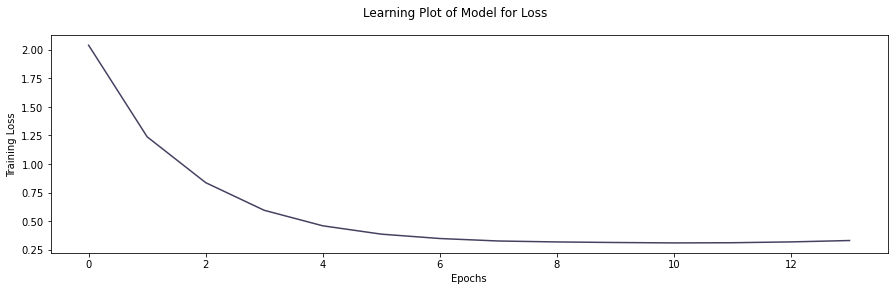

In [102]:
import seaborn as sns
import matplotlib.pyplot as plt
history_df = pd.DataFrame(history.history)
#Plotting the learnings 

fig = plt.figure(figsize=(15,4))
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")